<a href="https://colab.research.google.com/github/Sarah-chu/NLP-Deep-Learning-Hate_Speech_Detection/blob/main/NLP_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Put the required files in your Google drive.


Once the data ready, mont your drive inside this notebook with following code : 

from google.colab import drive

drive.mount('/gdrive')


### reference : 
https://www.stackabuse.com/python-for-nlp-movie-sentiment-analysis-using-deep-learning-in-keras/ 

In [1]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [2]:
pip install keras_metrics

## Importing Required Libraries

In [3]:
import os
import glob
import numpy as np
import pandas as pd
from tensorflow.keras import layers
from tensorflow import keras 
import tensorflow as tf
import re
import nltk
from numpy import array

import keras
import keras_metrics as km
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten
from keras.layers import GlobalMaxPooling1D
from keras.layers.embeddings import Embedding
from tensorflow.keras.layers import LSTM
from keras.preprocessing.text import Tokenizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
%matplotlib inline


## Connecting to GPU

In [4]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


## Importing dataset

In [5]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [7]:
data_dir  = "/gdrive/MyDrive/AI_and_Big_Data_Project/Dataset1_labeled_data.csv"

In [6]:
data_dir  = "/gdrive/MyDrive/career/master_in_france/course/AI_and_Big_Data_Project/Dataset1_labeled_data.csv"

In [7]:
data = pd.read_csv(data_dir)

In [8]:
data.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


## Data Preprocessing

In [9]:
# Create functions

def remove_links(tweet):
    '''Takes a string and removes web links from it'''
    tweet = re.sub(r'http\S+', '', tweet) # remove http links
    tweet = re.sub(r'bit.ly/\S+', '', tweet) # rempve bitly links
    tweet = tweet.strip('[link]') # remove [links]
    return tweet

def remove_users(tweet):
    '''Takes a string and removes retweet and @user information'''
    tweet = re.sub('(RT\s@[A-Za-z0-9-_]+[A-Za-z0-9-_]+)', '', tweet) # remove retweet
    tweet = re.sub('(@[A-Za-z0-9-_]+[A-Za-z0-9-_]+)', '', tweet) # remove tweeted at
    return tweet

In [10]:
my_stopwords = nltk.corpus.stopwords.words('english')
word_rooter = nltk.stem.snowball.PorterStemmer(ignore_stopwords=False).stem
my_punctuation = '!"$%&\'()*+,-./:;<=>?[\\]\\\\\^_`{|}~•@#'

# cleaning master function
def clean_tweet(tweet, bigrams=False):
    tweet = remove_users(tweet)
    tweet = remove_links(tweet)
    tweet = tweet.lower() # lower case
    tweet = re.sub('['+my_punctuation + ']+', ' ', tweet) # strip punctuation
    tweet = re.sub('\s+', ' ', tweet) #remove double spacing
    tweet = re.sub('([0-9]+)', '', tweet) # remove numbers
    tweet = re.sub('amp', '', tweet) # remove amp
    tweet = re.sub(r'\s+', ' ', tweet) # remove multiple spaces
    tweet_token_list = [word for word in tweet.split(' ')
                            if word not in my_stopwords] # remove stopwords

    tweet_token_list = [word_rooter(word) if '#' not in word else word
                        for word in tweet_token_list] # apply word rooter
    if bigrams:
        tweet_token_list = tweet_token_list+[tweet_token_list[i]+'_'+tweet_token_list[i+1]
                                            for i in range(len(tweet_token_list)-1)]
    tweet = ' '.join(tweet_token_list)
    return tweet

In [11]:
data['clean_tweet'] = data.tweet.apply(clean_tweet)
data.head(30)

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet,clean_tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...,woman complain clean hous man alway take trash
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,boy dat cold tyga dwn bad cuffin dat hoe st p...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,dawg ever fuck bitch start cri confus shit
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,look like tranni
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,shit hear might true might faker bitch told ya
5,5,3,1,2,0,1,"!!!!!!!!!!!!!!!!!!""@T_Madison_x: The shit just...",shit blow claim faith somebodi still fuck hoe
6,6,3,0,3,0,1,"!!!!!!""@__BrighterDays: I can not just sit up ...",sit hate anoth bitch got much shit go
7,7,3,0,3,0,1,!!!!&#8220;@selfiequeenbri: cause I'm tired of...,caus tire big bitch come us skinni girl
8,8,3,0,3,0,1,""" &amp; you might not get ya bitch back &amp; ...",might get ya bitch back that
9,9,3,1,2,0,1,""" @rhythmixx_ :hobbies include: fighting Maria...",hobbi includ fight mariam bitch


## Train-test Split

In [12]:
X = []
sentences = list(data['clean_tweet'])
for sen in sentences:
  X.append(sen)

In [13]:
X[100]

' lmaooooooooooo nigga lt bitch want like depress shit foh'

In [41]:
# Split our data into a training set and a testing set


y = np.array(data['class'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

Number of training and testing samples

In [15]:
print('# of Training Samples: {}'.format(len(X_train)))
print('# of Test Samples: {}'.format(len(X_test)))

# of Training Samples: 16604
# of Test Samples: 8179


In [16]:
num_classes = max(y_train) + 1
print('# of Classes: {}'.format(num_classes))

# of Classes: 3


In [42]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

## Preparing the Embedding Layer

## calculating initial bias

to encounter unbalanced dataset

=> We have to use class weights, which increase the loss value inversely proportional to the frequency of the class.

=> Using bias_intializer will make the model converge faster. This is done by taking log(corresponding class/ total - corresponding class)

=> Applying weighted metrics in the model evaluation(train, validation and test)

In [43]:
#calculating initial bias
total_count = len(X_train)

groups = pd.DataFrame(y_train, columns = ['Assignment group'])
group_count = groups['Assignment group'].value_counts().reset_index()
group_count.sort_values('index', inplace=True)

In [44]:
group_count

,index,Assignment group
2,0,723
0,1,9655
1,2,2075


In [45]:
group_count['denominator'] = total_count - group_count['Assignment group'] 
group_count['initial bias'] = np.log(group_count['Assignment group'] / group_count['denominator'])
initial_bias = np.array(group_count['initial bias'])
initial_bias

array([-2.78649572,  1.23857104, -1.60972703])

In [46]:
# integer encode sequences of words

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_val = tokenizer.texts_to_sequences(X_val)
X_test = tokenizer.texts_to_sequences(X_test)

In [47]:
from keras.preprocessing.sequence import pad_sequences

# Adding 1 because of reserved 0 index
vocab_size = len(tokenizer.word_index) + 1

maxlen = 50


#now use sequence padding to post append zeros inorder to equalize the sentence structure for all the records
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_val = pad_sequences(X_val, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

# Converts a class vector (integers) to binary class matrix
y_train = keras.utils.to_categorical(y_train, 3)
y_test = keras.utils.to_categorical(y_test, 3)
y_val = keras.utils.to_categorical(y_val, 3)


In [48]:
# Compute the weight of each class

from sklearn.utils.class_weight import compute_class_weight

y_integers = np.argmax(y_train, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))

y_integers = np.argmax(y_val, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_vweights = dict(enumerate(class_weights))

y_integers = np.argmax(y_test, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_tweights = dict(enumerate(class_weights))



In [49]:
d_class_weights


{0: 5.741355463347165, 1: 0.42993267736923874, 2: 2.0004819277108434}

For validation and test we need to add samplewise weights¶

In [69]:
#training dataset
y_train_trans = np.argmax(y_train, axis=1)

train_weight = []
#calculate class weight for each sample in validation data
for i in y_train_trans:
  train_weight.append(d_class_weights[i])

train_weights = np.array(train_weight)

##validation dataset
y_val_trans = np.argmax(y_val, axis=1)

val_weight = []
#calculate class weight for each sample in validation data
for i in y_val_trans:
  val_weight.append(d_class_vweights[i])

val_weights = np.array(val_weight)

#test dataset
y_test_trans = np.argmax(y_test, axis=1)

test_weight = []
#calculate class weight for each sample in validation data
for i in y_test_trans:
  test_weight.append(d_class_tweights[i])

test_weights = np.array(test_weight)

## GloVe embeddings

In [50]:
# Import the GloVe embeddings

from numpy import array
from numpy import asarray
from numpy import zeros

''' use GloVe embeddings to create our feature matrix
    you can find the txt file in the drive and download it. 
    or download from https://www.kaggle.com/bertcarremans/glovetwitter27b100dtxt 
    it is a document of pre-trained word vectors. '''

embeddings_dictionary = dict()
glove_file = open('/gdrive/MyDrive/career/master_in_france/course/AI_and_Big_Data_Project/glove.twitter.27B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [26]:
from numpy import array
from numpy import asarray
from numpy import zeros

''' use GloVe embeddings to create our feature matrix
    you can find the txt file in the drive and download it. 
    or download from https://www.kaggle.com/bertcarremans/glovetwitter27b100dtxt 
    it is a document of pre-trained word vectors. '''

embeddings_dictionary = dict()
glove_file = open('/gdrive/MyDrive/career/master_in_france/course/AI_and_Big_Data_Project/glove.twitter.27B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [51]:
# Create an embedding matrix 
# Rows : the index of the word in the corpus
# Columns : 100 (each column will contain the GloVe word embeddings for the words in the corpus)
embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [52]:
embedding_matrix.shape

(10801, 100)

## Text Classification with Simple Neural Network

In [74]:
model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)

model.add(Flatten())
model.add(Dense(3, activation='softmax', bias_initializer = tf.keras.initializers.Constant(initial_bias)))

model.summary()


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 50, 100)           1080100   
_________________________________________________________________
flatten_3 (Flatten)          (None, 5000)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 15003     
Total params: 1,095,103
Trainable params: 15,003
Non-trainable params: 1,080,100
_________________________________________________________________


In [76]:
#model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[km.precision(), km.recall()])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])



In [77]:
history = model.fit(X_train, y_train, batch_size=128, epochs=30, verbose=1,validation_data =(X_val, y_val))

Epoch 1/30
98/98 [==============================] - 1s 5ms/step - loss: 0.6641 - accuracy: 0.7806 - val_loss: 0.4771 - val_accuracy: 0.8215
Epoch 2/30
98/98 [==============================] - 0s 4ms/step - loss: 0.4267 - accuracy: 0.8405 - val_loss: 0.4290 - val_accuracy: 0.8420
Epoch 3/30
98/98 [==============================] - 0s 4ms/step - loss: 0.3714 - accuracy: 0.8628 - val_loss: 0.4126 - val_accuracy: 0.8504
Epoch 4/30
98/98 [==============================] - 0s 4ms/step - loss: 0.3466 - accuracy: 0.8701 - val_loss: 0.4058 - val_accuracy: 0.8562
Epoch 5/30
98/98 [==============================] - 0s 4ms/step - loss: 0.3377 - accuracy: 0.8782 - val_loss: 0.4019 - val_accuracy: 0.8571
Epoch 6/30
98/98 [==============================] - 0s 4ms/step - loss: 0.3181 - accuracy: 0.8803 - val_loss: 0.4001 - val_accuracy: 0.8583
Epoch 7/30
98/98 [==============================] - 0s 4ms/step - loss: 0.2966 - accuracy: 0.8889 - val_loss: 0.3991 - val_accuracy: 0.8579
Epoch 8/30
98/98 [==

In [78]:
score = model.evaluate(X_test, y_test, verbose=1)

256/256 [==============================] - 1s 2ms/step - loss: 0.4268 - accuracy: 0.8561


In [79]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.42680880427360535
Test Accuracy: 0.8560948967933655


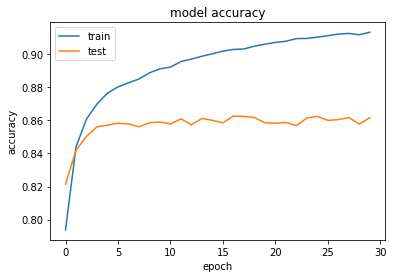

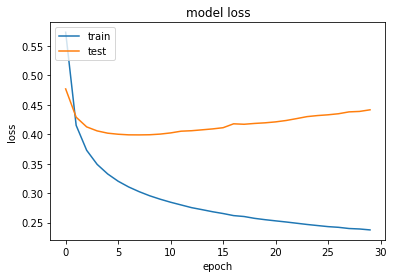

In [80]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

## Text Classification with Recurrent Neural Network (LSTM)

In [81]:
model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)
model.add(LSTM(128))

model.add(Dense(3, activation='softmax', bias_initializer = tf.keras.initializers.Constant(initial_bias)))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

print(model.summary())

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 50, 100)           1080100   
_________________________________________________________________
lstm_4 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 387       
Total params: 1,197,735
Trainable params: 117,635
Non-trainable params: 1,080,100
_________________________________________________________________
None


In [82]:
history = model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_data =(X_val, y_val))

score = model.evaluate(X_test, y_test, verbose=1)

Epoch 1/6
98/98 [==============================] - 2s 12ms/step - loss: 0.5993 - acc: 0.8132 - val_loss: 0.4023 - val_acc: 0.8834
Epoch 2/6
98/98 [==============================] - 1s 8ms/step - loss: 0.3838 - acc: 0.8864 - val_loss: 0.3515 - val_acc: 0.8950
Epoch 3/6
98/98 [==============================] - 1s 8ms/step - loss: 0.3259 - acc: 0.9014 - val_loss: 0.3968 - val_acc: 0.8677
Epoch 4/6
98/98 [==============================] - 1s 8ms/step - loss: 0.2998 - acc: 0.9022 - val_loss: 0.3183 - val_acc: 0.8904
Epoch 5/6
98/98 [==============================] - 1s 8ms/step - loss: 0.2819 - acc: 0.9054 - val_loss: 0.3202 - val_acc: 0.9032
Epoch 6/6
256/256 [==============================] - 1s 3ms/step - loss: 0.3028 - acc: 0.8911


In [83]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.3028392791748047
Test Accuracy: 0.8910624980926514


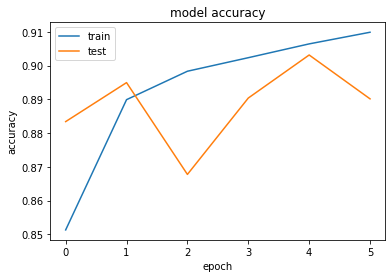

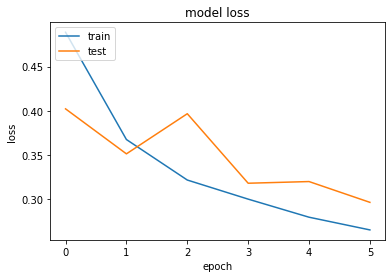

In [84]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()



When the input is heavily imbalanced.

=> We have to use class weights, which increase the loss value inversely proportional to the frequency of the class.

=> Using bias_intializer will make the model converge faster. This is done by taking log(corresponding class/ total - corresponding class)

=> Applying weighted metrics in the model evaluation(train, validation and test)

https://www.analyticsvidhya.com/blog/2020/11/handling-imbalanced-data-machine-learning-computer-vision-and-nlp/

https://github.com/NandhiniN85/Class-Imbalancing/blob/main/English_raw200_model_execution.ipynb

In [85]:
from tensorflow.keras.metrics import Precision, Recall, AUC, CategoricalAccuracy

METRICS = [      
      Precision(name='precision'),
      Recall(name='recall'),
      AUC(name='auc'),
      CategoricalAccuracy(name='accuracy')
]

In [92]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Flatten, Dense

model = Sequential()          #Defining a sequential layer
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)
model.add(Bidirectional(LSTM(units=100, dropout=0.2))) #LSTM return sequences
model.add(Flatten())

#!!!! IMPORTANT !!!!
#can test with both giving initial bias and without giving initial bias

model.add(Dense(3, activation='softmax', bias_initializer = tf.keras.initializers.Constant(initial_bias)))
#model.add(Dense(1, activation='softmax'))
model.summary()



Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 50, 100)           1080100   
_________________________________________________________________
bidirectional_3 (Bidirection (None, 200)               160800    
_________________________________________________________________
flatten_5 (Flatten)          (None, 200)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 3)                 603       
Total params: 1,241,503
Trainable params: 161,403
Non-trainable params: 1,080,100
_________________________________________________________________


In [93]:
model.compile(optimizer="Adam", loss="categorical_crossentropy", weighted_metrics=[METRICS])

In [94]:
checkpoint = ModelCheckpoint('model-{epoch:03d}-{val_accuracy:03f}.h5', verbose=1, monitor='val_accuracy',save_best_only=True, mode='auto') 
reduceLoss = ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=2, min_lr=0.0001)

In [95]:

history = model.fit(X_train, y_train, batch_size=32, class_weight = d_class_weights, epochs=8,callbacks=[checkpoint,reduceLoss],validation_data =(X_val, y_val, val_weights), verbose=1)

Epoch 1/8
390/390 [==============================] - 10s 18ms/step - loss: 0.9784 - precision: 0.6241 - recall: 0.5049 - auc: 0.7540 - accuracy: 0.5889 - val_loss: 0.5704 - val_precision: 0.7886 - val_recall: 0.7548 - val_auc: 0.9114 - val_accuracy: 0.7739

Epoch 00001: val_accuracy improved from -inf to 0.77388, saving model to model-001-0.773880.h5
Epoch 2/8
390/390 [==============================] - 5s 14ms/step - loss: 0.5268 - precision: 0.8027 - recall: 0.7705 - auc: 0.9247 - accuracy: 0.7871 - val_loss: 0.5331 - val_precision: 0.8116 - val_recall: 0.7770 - val_auc: 0.9220 - val_accuracy: 0.7975

Epoch 00002: val_accuracy improved from 0.77388 to 0.79753, saving model to model-002-0.797534.h5
Epoch 3/8
390/390 [==============================] - 6s 15ms/step - loss: 0.5006 - precision: 0.8114 - recall: 0.7795 - auc: 0.9334 - accuracy: 0.7954 - val_loss: 0.4978 - val_precision: 0.8184 - val_recall: 0.7790 - val_auc: 0.9321 - val_accuracy: 0.8021

Epoch 00003: val_accuracy improved 

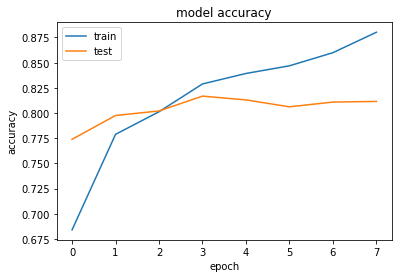

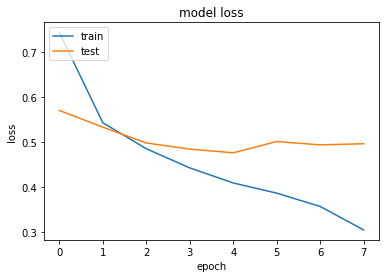

In [96]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()